In [46]:
# #-- Lib install
# !pip install yfinance==0.2.10 -q
# !pip install pyyaml h5py -q
# !pip install yahoo-finance -q
# !pip install statsmodels -q

# Train

In [1]:
import pandas as pd
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import seaborn as sns
import time
import matplotlib.pyplot as plt
import numpy as np

def config_param(MLmodel, param, cv= 10, n_jobs=-1, scoring = 'balanced_accuracy'):
    
    grid_class = GridSearchCV(MLmodel, param, cv=cv,n_jobs=n_jobs, scoring = scoring)
    
    return MLmodel, grid_class

def get_param(MLmodel, param, X,Y):    
    
    MLmodel, grid_class = config_param(MLmodel, param)
    
    return grid_class.fit(X,Y)


def best_model(MLmodel,data_X,data_y,param):
  print('----------------')
  print('Início do CVGrid')
  inicio = time.time()
  all_param = get_param(MLmodel, param, data_X,data_y)
  best_result = all_param.best_estimator_
  final = time.time() - inicio
  min = final/60 
  print('Final do CVGrid')
  print('Tempo de Execução: {} min '.format(min))
  print('----------------')
  return best_result

def plot_results(y_pred,y_real):

  ### Função de plotagem da matriz de confusão ###

  ''' Esta função realiza o plot da matriz de confusão para análise visual do desempenho '''

  # Criando a matrix de confusão para análise de eficiência
  cnf_matrix = metrics.confusion_matrix(y_pred, y_real)
  
  # Plotagem da matriz de confusão e um Heatmap
  class_names=[0,1] #  Nome das classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  
  # Creando o heatmap com a matriz de confusão
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("bottom")
  plt.tight_layout()
  plt.title('Matriz de Confusão', y=1.1)
  plt.ylabel('Valor real')
  plt.xlabel('Valor previsto')


def get_metrics(y_true, y_pred):
    metrics_dict = {
        'ACCUR': metrics.accuracy_score(y_true, y_pred),
        'PREC': metrics.precision_score(y_true, y_pred),
        'RECC': metrics.recall_score(y_true, y_pred),
        'F1': metrics.f1_score(y_true, y_pred),
        'BAL_ACCUR': metrics.balanced_accuracy_score(y_true, y_pred)
    }

    return metrics_dict

df_train = pd.read_csv('../Dataset/Main/df_train.csv')
df_train['Date'] = pd.to_datetime(df_train['Date'])

#df_train = df_train[df_train.Empresa == 'Apple'].reset_index(drop=True)

val_scaler = df_train.groupby('Empresa').agg({'Close':['max','min']})
df_train['Close'] = df_train.apply(lambda x: apply_scaler(x, val_scaler),axis=1)
joblib.dump(val_scaler, '../Model/Close_scaler')
del val_scaler

Coef_scaler = StandardScaler()
coef_cols = [x for x in df_train.columns if 'coef' in x]
df_train[coef_cols] = Coef_scaler.fit_transform(df_train[coef_cols])
joblib.dump(Coef_scaler, '../Model/Coef_scaler')
del Coef_scaler

Volume_scaler = StandardScaler()
df_train[['Volume']] = Volume_scaler.fit_transform(df_train[['Volume']])
joblib.dump(Volume_scaler, '../Model/Volume_scaler')
del Volume_scaler


target_list = [1,2]
df_train = df_train[df_train.target.isin(target_list)].reset_index(drop=True)

df_train.head()


FileNotFoundError: [Errno 2] No such file or directory: '../Dataset/Main/df_train.csv'

In [ ]:
Close_scaler = joblib.load('../Model/Close_scaler')
Coef_scaler = joblib.load('../Model/Coef_scaler')
Volume_scaler = joblib.load('../Model/Volume_scaler')
coef_cols = [x for x in df_train.columns if 'coef' in x]

In [ ]:
# sns.pairplot(df_train,hue='Action', palette='icefire')

In [ ]:
from sklearn.svm import NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [ ]:
rus = RandomUnderSampler(random_state=0)

X = df_train[['Close','Volume','coef_3', 'coef_7', 'coef_10', 'coef_15', 'coef_20', 'coef_30']]
y = df_train[['target']]

X_resampled, y_resampled = rus.fit_resample(X, y)

0.9197255574614065

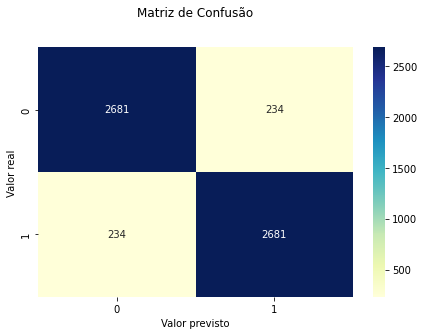

In [ ]:


AdaBoost_class = LogisticRegression() # MLPClassifier(hidden_layer_sizes=(200,200,100),max_iter=200)
AdaBoost_class.fit(X_resampled, y_resampled)



y_pred = AdaBoost_class.predict(X_resampled)
y_true = y_resampled

plot_results(y_pred,y_true)
metrics.accuracy_score(y_true, y_pred)


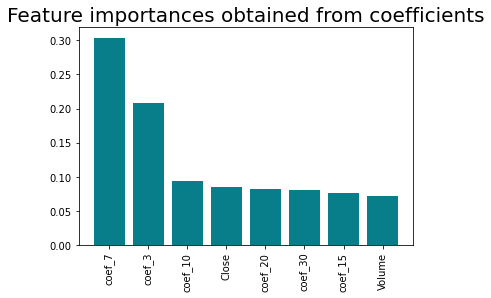

In [ ]:
importances = pd.DataFrame(data={
    'Attribute': X_resampled.columns,
    'Importance': AdaBoost_class.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

              precision    recall  f1-score   support

           1       0.92      0.93      0.93       144
           2       0.92      0.92      0.92       133

    accuracy                           0.92       277
   macro avg       0.92      0.92      0.92       277
weighted avg       0.92      0.92      0.92       277



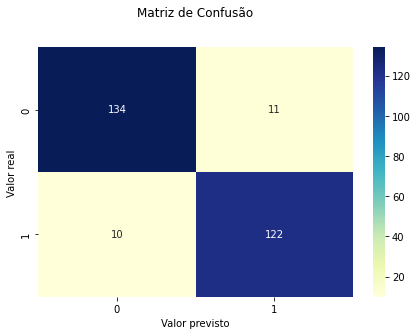

In [ ]:
df_test = pd.read_csv('../Dataset/Main/df_test.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test = df_test[df_test.target.isin(target_list)].reset_index(drop=True)

#df_test = df_test[df_test.Empresa == 'Apple'].reset_index(drop=True)
df_test[coef_cols] = Coef_scaler.transform(df_test[coef_cols])
df_test[['Volume']] = Volume_scaler.transform(df_test[['Volume']])
df_test['Close'] = df_test.apply(lambda x: apply_scaler(x, Close_scaler),axis=1)

X = df_test[['Close','Volume','coef_3', 'coef_7', 'coef_10', 'coef_15', 'coef_20', 'coef_30']]
y = df_test[['target']]

y_pred = AdaBoost_class.predict(X)
y_true = y
plot_results(y_pred,y_true)
print(metrics.classification_report(y_true,y_pred))



# Test

In [ ]:


param = {'base_estimator':[DecisionTreeClassifier(max_depth=5)],
         'n_estimators':[10, 50],
         'algorithm':['SAMME.R'],
         'learning_rate':[0.5, 1, 1.5, 2]
        }

MLmodel = AdaBoostClassifier()
BestModel = best_model(MLmodel, X_resampled, y_resampled,param)



In [3]:
import pandas as pd
import seaborn as sns
df = pd.read_csv(f'/Users/cora/Documents/mba_uspesalq_tcc/Dataset/Main/amazon_main.csv')
# df['Date'] = pd.to_datetime(df['Date'])
# df['Mean'] = df['Close'].rolling(3).mean()

# df['Dif'] = df['Open'] - df['Close']

# df['loc_min'] = df.iloc[argrelextrema(df.Close.values, np.less_equal, order = n, mode='wrap',)[0]]['Close']
# df['loc_max'] = df.iloc[argrelextrema(df.Close.values, np.greater_equal, order = n, mode='wrap',)[0]]['Close']
# df['teste_max0'] = df['loc_max'].apply(lambda x: 1 if x > 0 else 0) 
# df['teste_max1'] = df['teste_max0'].shift(1)
# df['teste_max2'] = df['teste_max0'].shift(-1)
# df['teste_min0'] = df['loc_min'].apply(lambda x: 2 if x > 0 else 0) 
# df['teste_min1'] = df['teste_min0'].shift(1)
# df['teste_min2'] = df['teste_min0'].shift(-1)
# df['target'] = df[['teste_max0','teste_max1','teste_max2',
#                         'teste_min0','teste_min1','teste_min2']].sum(axis=1).astype(int)
# df['moment'] = df['target'].apply(lambda x: classify_sample(x))
# df['Action'] = df['moment'].apply(lambda x: 0 if x == 'hold' else 1)

# df = df[['Date','Close','Mean','Dif','Volume','Empresa', 'Symbol','target', 'moment', 'Action']].reset_index(drop=True)

<Axes: xlabel='Date', ylabel='Close'>

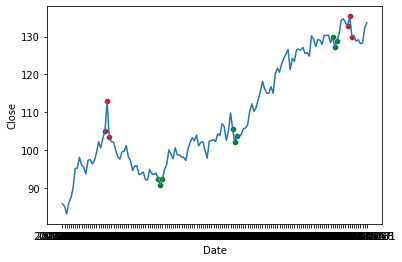

In [11]:
df_temp = df[df.Date >= '2023-01-01'].copy()

sns.lineplot(data=df_temp,x='Date',y='Close')
sns.scatterplot(data=df_temp[df_temp.moment=='buy'],x='Date',y='Close',c='g')
sns.scatterplot(data=df_temp[df_temp.moment=='sell'],x='Date',y='Close',c='r')